# Inference

Run the cell below and a option to upload the image will apear in the output of cell. Upload the image (for testing you can upload from ./test_images/ folder) and model will proces it

FileUpload(value=(), accept='image/*', description='Upload')

Processing file: ./temp_folder/FudanPed00060.png
Running on device :  cuda


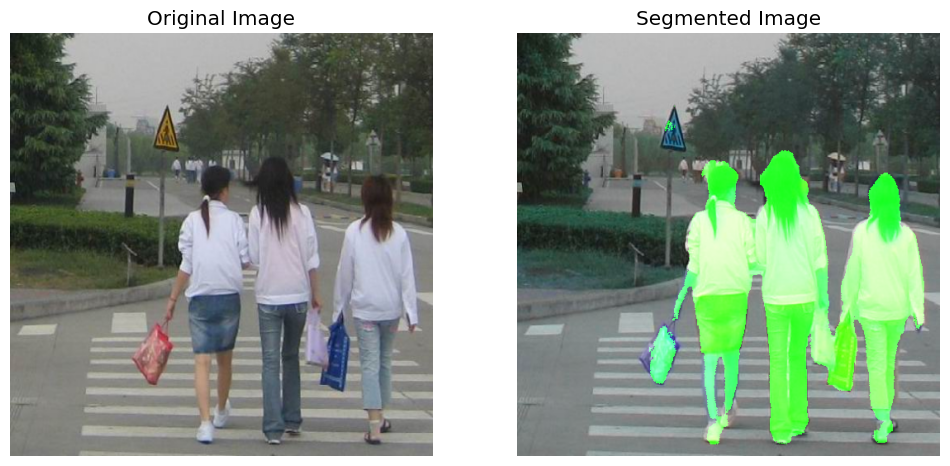

Processing file: ./temp_folder/img3.png
Running on device :  cuda


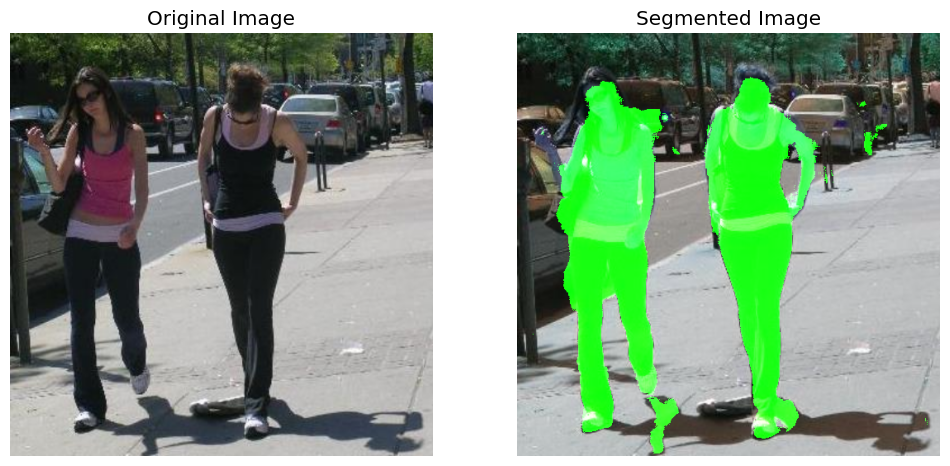

In [1]:
import torch
import cv2
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

from utils import get_segment_labels, draw_segmentation_map, image_overlay
from model import UNet
from config import ALL_CLASSES


TEMP_DIR = "./temp_folder/"


def load_model(model_path, device):
    model = UNet(num_classes=len(ALL_CLASSES)).to(device)
    ckpt = torch.load(model_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    return model

def process_image(image_path, resize):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if resize is not None:
        image = cv2.resize(image, (int(resize), int(resize)))
        
    image_copy = image.copy()
    image_copy = image_copy / 255.0
    image_tensor = torch.permute(
        torch.tensor(image_copy, dtype=torch.float32), (2, 0, 1)
    )
    
    return image, image_tensor

def display_result(original_image, segmented_image):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmented Image")
    plt.imshow(segmented_image)
    plt.axis('off')
    
    plt.show()

def main(model_path, image_path, resize=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Running on device : ", device)
    
    model = load_model(model_path, device)
    
    original_image, image_tensor = process_image(image_path, resize)
    
    outputs = get_segment_labels(image_tensor, model, device)
    segmented_image = draw_segmentation_map(outputs)
    
    final_image = image_overlay(original_image, segmented_image)
    
    display_result(original_image, final_image)
    shutil.rmtree(TEMP_DIR, ignore_errors=True)

def upload_and_process(model_path):
    uploader = widgets.FileUpload(
        accept='image/*',  # Accept image files only
        multiple=False  # Single file upload
    )
    
    def on_upload_change(change):
        uploaded_file = uploader.value
        if uploaded_file:
            if os.path.exists(TEMP_DIR):
                shutil.rmtree(TEMP_DIR, ignore_errors=True)
            os.makedirs(TEMP_DIR)
            # Access file content
            file_name = uploaded_file[0]["name"]
            file_content = uploaded_file[0]['content']
            # Save the file
            
            file_name = os.path.join(TEMP_DIR, file_name)
            
            with open(file_name, 'wb') as f:
                f.write(file_content)
            print(f"Processing file: {file_name}")
            main(model_path, file_name, resize=512)

    uploader.observe(on_upload_change, names='value')
    display(uploader)

if __name__ == '__main__':
    model_path = "./outputs/model.pth"
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR, ignore_errors=True)
            
    os.makedirs(TEMP_DIR)
    upload_and_process(model_path)
    
